In [1]:
import pytrec_eval 
import json
import re
import numpy as np
import sys
import codecs
import struct

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from elasticsearch import Elasticsearch, ElasticsearchException, SerializationError,TransportError

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from pprint import pprint
es = Elasticsearch("localhost:9211", log="trace", timeout=1000)
print(es)

<Elasticsearch([{'host': 'localhost', 'port': 9211}])>


In [2]:
class PRCurve:
    REC_ARR=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    def __init__(self, label,  precarr, linestyle=None, color=None):
        self.plt=plt
        self.label=label
        self.precarr=list(precarr)
        self.linestyle=linestyle
        self.color=color
        self.ydata=[]
        self.l2d=None
    
    def mp_plot(self, linestyle=None, color=None):
        if linestyle==None and color==None:
            self.l2d =plt.plot(self.REC_ARR, self.precarr, label=self.label)[0]
        else:
            self.l2d =plt.plot(x=self.REC_ARR, y=self.precarr, label=self.label, linestyle=linestyle, color=color)[0]
        return self.l2d

class CurveWithLabel:
    REC_ARR=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    def __init__(self, averages, name):
        self.plt=plt
        self.name=name
        self.averages=averages
        self.summary_measures=self.extract()
        self.label=self.make_label()
        self.l2d=self.mp_plot()
        
    def extract(self):
        summary_measures=dict()
        print("self.averages:",self.averages)
        for ky in list(self.averages.keys()):
            if 'iprec' not in ky:
                summary_measures.update({ky : self.averages[ky]})
                _=self.averages.pop(ky)
                
        return summary_measures
    
    def make_label(self):
        ret=self.name+":"
        for ky in self.summary_measures:
            val=self.summary_measures[ky]
            ret += " " + ky + "=" + str(val)[0:5] +","
        ret=ret.strip(',')    
        return ret
    
    def mp_plot(self, linestyle=None, color=None):
        p=PRCurve(self.label, self.averages.values(), linestyle=linestyle, color=color)
        p.mp_plot(linestyle=linestyle, color=color)
        return p.l2d

In [3]:
index_name = "publication"
doc_type = "html"
remove_stopwords = True
stem = False
queryfile="query.txt"

INDEX_SETTINGS = {  # two shards with a single replica
    "settings" : {
        "index" : {
            "number_of_shards" : 6,
            "number_of_replicas" : 1
           #,"similarity" : { "default" : { "type" : "LMJelinekMercer", "lambda":"0.4" }
            }
        }
        ,
    "mappings": {
            "html": {
            "properties": {
#                "post_date": { "type": "date" }
#                ,
                "title": {"type": "text" }
                ,
#                "id": { "type": "keyword"}
#                ,
                "text": { "type": "text" }
                ,
                "description": {"type": "text"}
                ,
                "keywords": {"type": "keyword"}
                ,
                "classification":{"type": "text"}
                }
            }
        }
    }

DCTR=0
DOCS_IN_FILE=0
es = Elasticsearch("localhost:9211", timeout=100)
if es.indices.exists(index_name):
    print("index exists")
    #es.indices.delete(index=INDEX_NAME)
else:
    print("cannot")
    sys.exit()
#pprint (es.indices.stats(index="publication"))

body = {
	
    "size": 20,           # get 100 docs (default = 10)
    "_source": ["work", "work.subjects"], # get only wanted fields
	 "query": { 
         "query_string":{"query":"charlotte brontë"}# the query
	 }
}
es.indices.open(index="publication")
es.indices.refresh(index="publication")

result=es.search(index="publication", body=body)

type(result)
#pprint(result)

index exists


dict

In [4]:

def printHit(qr, hit):
    print("Q::", qr, "_id:", hit['_id'])
    
    source=hit['_source']
    if 'author' in source:
        print("   Author:",source['author'][0])
    if  'mainTitle' in source:
        print("           Title:",source['mainTitle'])
    print("                 _score:", hit['_score'])
       
def process_query(query):
    body = {
	
        "size": 20,           # get 20 docs (default = 10)
        "_source": ["mainTitle", "author"], # get only wanted fields
         "query": { 
             "query_string":{"query":query}}#,
     #"sort" : "_score"    
	}
    return body   



In [11]:
from collections import OrderedDict
def removeOldSimilaritySettingSetting(val_dict, index):
    old_settings=es.indices.get_settings(index=index)
    old_sim= old_settings['publication']['settings']['index']['similarity']['default']
    print("old_sim:", old_sim)
    for setting in old_sim:
        if setting not in val_dict:
            if setting=="normalization.h2":
                setting="normalization.h2.c"
            val_dict[setting]=None 
    return val_dict

def run(es=es, 
        index="publication", 
        queryfile="query.txt",
        qrelfile="qrels.query.adhoc",
        similarity="DFR",#None,#"DFR", 
        parameterNames=["basic_model", "after_effect", "normalization", "normalization.h2.c"],#None,#["basic_model", "after_effect", "normalization", "normalization.h2.c"], 
        parameterValues=["g",          "l",            "h2", "4.0"]#None#["g",          "l",            "h2", "4.0"]
       ):
    print("s:",similarity, "pn:",parameterNames, "pv:",parameterValues)
    es.indices.close(index=index)
    
    #FILTER AWAY OLD SIMILARITY SETTINGS
    val_dict=OrderedDict()
    val_dict["type"]=similarity
    
    for i in range(len(parameterNames)):
        val_dict[parameterNames[i]]=parameterValues[i]
    val_dict=removeOldSimilaritySettingSetting(val_dict, index)
    val_dict=dict(val_dict)    
    print("val_dict=", val_dict)
    #my_dict={"my_"+similarity:val_dict}
    def_dict={"default":val_dict}
    print("def_dict=", def_dict)
    sim_dict= {"similarity": def_dict}
    setting_dict={"index":sim_dict}
    similarity_setting=json.JSONEncoder().encode(setting_dict)
    print("settings::::")
    pprint(similarity_setting)
    es.indices.put_settings(index=index, body=similarity_setting)
    es.indices.open(index=index)
    es.indices.refresh(index=index)
    
    qrels=dict()
    with open(qrelfile, 'r') as myfile: 
            qrel_lines=myfile.readlines()

    for line in qrel_lines:
        qnr, zero, docnr, rel=line.split()
        if qnr not in qrels.keys():
            qrels[qnr]=dict()
        qrels[qnr][docnr]=int(rel)

    queries=dict()
    with open(queryfile) as qfile:
        qlines=qfile.readlines()

    for line in qlines:
        qnr, qstring=line.split(':')
        qstring=qstring.strip('\n')
        if qnr not in queries.keys():
            queries[qnr]=qstring

    run=OrderedDict()  
    print("starting search")
    for qr in queries.keys():
        
        query=queries[qr]
        processed_query=process_query(query)
        #print("processed_query=",processed_query)
        
        #res = es.search(index=index_name, q=query, _source=False, size=20)
        res = es.search(index=index_name, body=processed_query, _source=True, sort="_score")
        for hit in res['hits']['hits']:
            printHit(qr, hit)#Kommenter vekk for å slippe utskrift
            if qr not in run.keys():
                #Make a new dictionary for next query
                run[qr]=OrderedDict()
            run[qr][hit['_id']]=hit['_score']    
    #printRun(run)
    evaluator = pytrec_eval.RelevanceEvaluator(
        qrels, { 'iprec_at_recall', 'map', 'ndcg', 'Rprec'})
    eval=evaluator.evaluate(run)
    

    avres=dict()
    
    for q in eval.keys():
        for res in eval[q].keys():
            if res not in avres.keys():
                avres[res]=0 #initialize
            avres[res]+=eval[q][res]/len(eval)#update average
        
    return avres

def plotCombined(cwls):
    colors=['red', 'aqua', 'darkmagenta', 'sienna', 'brown', 'grey']
    linestyles=['-', '--', '-.', '.', ':', '-' ]
    l2ds=list()
    ax=None
    for c in range(len(cwls)):
        cwl=cwls[c]
        ls=linestyles[c]
        color=colors[c]
       
        l2ds.append(cwl.mp_plot())
    
    plt.legend()
    plt.show()

curvesWithLabels=list()

# Call to run function

In [12]:
{'_index': 'publication', 
 '_type': '_doc', 
 '_id': 'http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fpd47f25221821f19d368414b1e31da90b', 
 '_score': 20.602264, 
 '_source': {'work': {'mainTitle': 'Jane Austen'}}}

{'_index': 'publication',
 '_type': '_doc',
 '_id': 'http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fpd47f25221821f19d368414b1e31da90b',
 '_score': 20.602264,
 '_source': {'work': {'mainTitle': 'Jane Austen'}}}

s: LMJelinekMercer pn: ['lambda'] pv: ['0.4']
old_sim: {'basic_model': 'g', 'type': 'DFR', 'normalization': 'h2', 'after_effect': 'l', 'normalization.h2': {'c': '4.0'}}
val_dict= {'type': 'LMJelinekMercer', 'lambda': '0.4', 'basic_model': None, 'normalization': None, 'after_effect': None, 'normalization.h2.c': None}
def_dict= {'default': {'type': 'LMJelinekMercer', 'lambda': '0.4', 'basic_model': None, 'normalization': None, 'after_effect': None, 'normalization.h2.c': None}}
settings::::
('{"index": {"similarity": {"default": {"type": "LMJelinekMercer", "lambda": '
 '"0.4", "basic_model": null, "normalization": null, "after_effect": null, '
 '"normalization.h2.c": null}}}}')
starting search
Q:: 101 _id: http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fpd47f25221821f19d368414b1e31da90b
   Author: Shields, Carol
           Title: Jane Austen
                 _score: 20.30885
Q:: 101 _id: http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fp61a133129dbdaab001b266756cc8d403
   Author: Lefroy, Helen

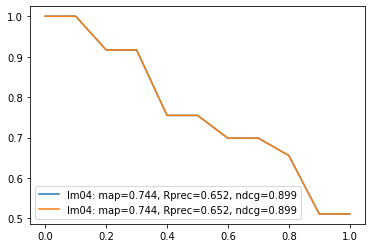

In [13]:
curvesWithLabels=list()
avres=run(es, similarity="LMJelinekMercer",parameterNames=["lambda"], parameterValues=["0.4"])#LMJelinekMercer
lm04=CurveWithLabel(avres, "lm04")
curvesWithLabels.append(lm04)

plotCombined(curvesWithLabels)

s: BM25 pn: ['k1', 'b'] pv: ['1.2', '0.75']
old_sim: {'type': 'LMJelinekMercer', 'lambda': '0.4'}
val_dict= {'type': 'BM25', 'k1': '1.2', 'b': '0.75', 'lambda': None}
def_dict= {'default': {'type': 'BM25', 'k1': '1.2', 'b': '0.75', 'lambda': None}}
settings::::
('{"index": {"similarity": {"default": {"type": "BM25", "k1": "1.2", "b": '
 '"0.75", "lambda": null}}}}')
starting search
Q:: 101 _id: http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fpd47f25221821f19d368414b1e31da90b
   Author: Shields, Carol
           Title: Jane Austen
                 _score: 28.344923
Q:: 101 _id: http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fp61a133129dbdaab001b266756cc8d403
   Author: Lefroy, Helen
           Title: Jane Austen
                 _score: 28.344923
Q:: 101 _id: http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fp764941012051
   Author: Sánchez Vegara, Ma Isabel
           Title: Jane Austen
                 _score: 28.344923
Q:: 101 _id: http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fp399401752320


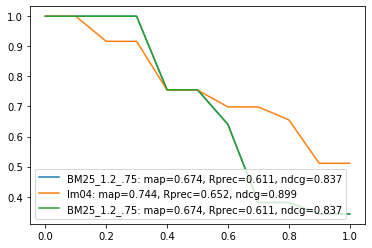

In [14]:
avres=run(es, similarity="BM25",parameterNames=["k1", "b"], parameterValues=["1.2", "0.75"])#LMJelinekMercer
bm25_def=CurveWithLabel(avres, "BM25_1.2_.75")
curvesWithLabels.append(bm25_def)

plotCombined(curvesWithLabels)

s: DFR pn: ['basic_model', 'after_effect', 'normalization', 'normalization.h2.c'] pv: ['g', 'l', 'h2', '4.0']
old_sim: {'type': 'BM25', 'b': '0.75', 'k1': '1.2'}
val_dict= {'type': 'DFR', 'basic_model': 'g', 'after_effect': 'l', 'normalization': 'h2', 'normalization.h2.c': '4.0', 'b': None, 'k1': None}
def_dict= {'default': {'type': 'DFR', 'basic_model': 'g', 'after_effect': 'l', 'normalization': 'h2', 'normalization.h2.c': '4.0', 'b': None, 'k1': None}}
settings::::
('{"index": {"similarity": {"default": {"type": "DFR", "basic_model": "g", '
 '"after_effect": "l", "normalization": "h2", "normalization.h2.c": "4.0", '
 '"b": null, "k1": null}}}}')
starting search
Q:: 101 _id: http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fpd47f25221821f19d368414b1e31da90b
   Author: Shields, Carol
           Title: Jane Austen
                 _score: 20.602264
Q:: 101 _id: http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fp61a133129dbdaab001b266756cc8d403
   Author: Lefroy, Helen
           Title: Jane Aus

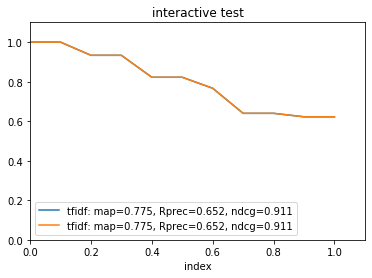

In [15]:
curvesWithLabels=list()

plt.ion() #Turn on interactive mode
plt.axis([0.0, 1.1, 0.0, 1.1])
plt.title("interactive test")
plt.xlabel("index")

#call here, overriding default parameters for models
avres=run(es, similarity= "DFR",
          parameterNames=["basic_model", "after_effect", "normalization", "normalization.h2.c"],
          parameterValues=["g",          "l",            "h2", "4.0"])
tfidf=CurveWithLabel(avres, "tfidf")

curvesWithLabels.append(tfidf)
plotCombined(curvesWithLabels)

s: DFR pn: ['basic_model', 'after_effect', 'normalization', 'normalization.h2.c'] pv: ['g', 'l', 'h2', '4.0']
old_sim: {'basic_model': 'g', 'type': 'DFR', 'normalization': 'h2', 'after_effect': 'l', 'normalization.h2': {'c': '4.0'}}
val_dict= {'type': 'DFR', 'basic_model': 'g', 'after_effect': 'l', 'normalization': 'h2', 'normalization.h2.c': None}
def_dict= {'default': {'type': 'DFR', 'basic_model': 'g', 'after_effect': 'l', 'normalization': 'h2', 'normalization.h2.c': None}}
settings::::
('{"index": {"similarity": {"default": {"type": "DFR", "basic_model": "g", '
 '"after_effect": "l", "normalization": "h2", "normalization.h2.c": null}}}}')
starting search
Q:: 101 _id: http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fpd47f25221821f19d368414b1e31da90b
   Author: Shields, Carol
           Title: Jane Austen
                 _score: 18.176563
Q:: 101 _id: http%3A%2F%2Fdata.deichman.no%2Fpublication%2Fp61a133129dbdaab001b266756cc8d403
   Author: Lefroy, Helen
           Title: Jane Austen
 

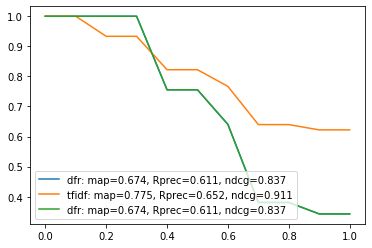

In [16]:
avres=run(es)# DFR is the default, see def run() above
dfr=CurveWithLabel(avres, "dfr")
curvesWithLabels.append(dfr)
plotCombined(curvesWithLabels)